## Imports

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from FlowCytometryTools import FCMeasurement
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

## Helper functions

In [3]:
def summorize_fcs(meta, data_path):
    '''
    Function that writes medians of each channel into a file
    :param meta: pandas dataframe with metadata with the following columns: 
        file_name, sample_id, condition, patient_id. See example of the metadata table below
    
    :param data_path: path to .fsc files
    
    ** Windows Users **

    Windows uses the backslash character (‘\’) for paths. However, the backslash character
    is a special character in python that is used for formatting strings. 
    In order to specify paths correctly, you must precede the path with the character ‘r’.

    Good:

    >>> data_path=r'C:\data\'
    Bad:

    >>> data_path='C:\data\'
    
    
    :returns: 1) dataframe markers by samples
    2) dictionary with markers as keys and a median values for healthy and patients
    
    '''
    
    files = list(meta.file_name)
    status = list(meta.condition)
    samp = list(meta.sample_id)
    #open the first file to retrieve the order of markers
    sample = FCMeasurement(ID='Sample', datafile=data_path +files[0])
    dat1 = sample.data
    genes = dat1.columns
    genes = [x.split("_")[1] for x in genes]

    # matrix with medians for each marker and each sample
    medians_full = np.zeros((len(genes), len(samp)))
    # dictionary with medians for each sample and each condition
    medians_cond = dict()

    # file processing is performed per marker to avoid loading too much data into memory
    for i in range(len(genes)):
        gene = genes[i]
        old = 0
        for j in range(len(files)):
            st = status[j]
            file = files[j]
            gr = samp[j]
            sample = FCMeasurement(ID='Sample', datafile=data_path +file)
            dat1 = sample.data
            gs = dat1.columns
            genes_new = [x.split("_")[1] for x in gs]
            dat1.columns = genes_new
            new_dat = dat1[[gene]]
            new_dat.columns = ["expression"]
            new_dat["group"] = [gr]*dat1.shape[0]
            new_dat["antibody"] = [gene]*dat1.shape[0]
            new_dat["status"] = [st]*dat1.shape[0]
            new_dat.index = np.arange(old,dat1.shape[0]+old)
            old = dat1.shape[0] + old
            if j == 0:
                all_dat = new_dat.copy()
            else:    
                all_dat = pd.concat([all_dat, new_dat])
        #data transformation
        all_dat.expression = np.arcsinh(all_dat.expression/5)
        #medians for healthy and patients
        hp = all_dat['expression'][all_dat['status'] == 'healthy']
        cp = all_dat['expression'][all_dat['status'] == 'patient']
        medians_cond[gene] = [np.median(hp), np.median(cp)]
        #medians for each sample
        for j in range(len(samp)):
            s = samp[j]
            condition = (all_dat['group'] == s) 
            vals = all_dat['expression'][condition]
            medians_full[i,j] = np.median(vals)
    medians_full = pd.DataFrame(medians_full, index = genes, columns = samp)
    return(medians_full, medians_cond)


def pv_estimate(dat, markers, model):
    '''
    Computes p-values based on LMM and then performs FDR correction
    :param dat: pandas dataframe
    :param markers: a list of markers to test
    :param model: a string with model description
    '''
    pvs = []
    for m in markers:
        d = dat[dat.marker == m]
        md = smf.mixedlm(model,d ,
                     groups=d["samples"])
        try:
            mdf = md.fit()

            pvs.append((m,mdf.pvalues[1]))
        except np.linalg.LinAlgError:
            pvs.append((m,np.nan))
    # for correction we save only those p-values that were actually computed and did not crash due to 0 variance
    ms = []
    ps = []
    for g,p in pvs:
        if not np.isnan(p):
            ps.append(p)
            ms.append(g)
    #FDR correction
    _, new_pv = sm.stats.fdrcorrection(ps, alpha=0.05, method='indep', is_sorted=False)
    result = dict()
    for i in range(len(new_pv)):
        result[ms[i]] = new_pv[i]
    return(result)
        

## 1. Reading and summorizing the data

### 1.1 Not activated samples

### Metadata:

In [4]:
meta_na = pd.read_excel("data/meta_11vs8.xlsx", sheet_name="Sheet1")
display(meta_na)

,file_name,sample_id,condition,patient_id
0,CVD001B_platelets.fcs,CVD001B,healthy,CVD001
1,CVD002B_platelets.fcs,CVD002B,patient,CVD002
2,CVD003B_platelets.fcs,CVD003B,healthy,CVD003
3,CVD005B_platelets.fcs,CVD005B,patient,CVD005
4,CVD006B_platelets.fcs,CVD006B,healthy,CVD006
5,CVD007B_platelets.fcs,CVD007B,healthy,CVD007
6,CVD008B_platelets.fcs,CVD008B,patient,CVD008
7,CVD009B_platelets.fcs,CVD009B,patient,CVD009
8,CVD010B_platelets.fcs,CVD010B,healthy,CVD010
9,CVD011B_platelets.fcs,CVD011B,healthy,CVD011


### Reading .fcs and summarising the data into medians

In [5]:
# please first run the R script
files = "data/files_na/"
medians_full_na, medians_cond_na = summorize_fcs(meta_na, files)

In [6]:
medians_full_na.head()

,CVD001B,CVD002B,CVD003B,CVD005B,CVD006B,CVD007B,CVD008B,CVD009B,CVD010B,CVD011B,CVD013B,CVD016B,CVD017B,CVD018B,CVD019B,CVD012B,CVD020B,CVD021B,CVD023B
CD41,1.719918,2.907555,2.003366,1.708230,1.221145,1.807720,2.743881,2.734882,1.899686,2.207711,2.701118,2.157668,2.484318,2.218575,1.673136,1.886770,1.420781,2.347861,2.291936
CD40,0.000000,0.240208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182361,0.058243,0.000000,0.000000,0.000000,0.000000,0.068199,0.000000
CD42b,3.145262,3.822243,3.813913,3.288309,2.728734,3.292338,3.881372,3.711434,3.282439,3.471381,3.928452,3.561646,3.690780,3.494442,3.026161,3.075569,2.884299,3.738329,3.191075
CD31,1.969438,2.599228,2.530755,2.007859,1.628832,2.174342,2.604901,2.508372,2.462188,2.661136,2.885316,2.528056,2.516539,2.508850,1.959789,2.151594,1.741305,2.671195,2.358605
CD61,2.149691,3.209377,2.497750,2.273208,1.661972,2.264620,3.277990,3.274646,2.364371,2.638115,3.092663,2.577817,2.847444,2.664468,2.083762,2.219617,1.745072,2.944248,2.678250


### 1.2 Activated samples

In [8]:
meta_act = pd.read_excel("data/meta_11vs8_activated.xlsx", sheet_name="Sheet1")
display(meta_act)

,file_name,sample_id,condition,patient_id
0,CVD001A_platelets.fcs,CVD001A,healthy,CVD001
1,CVD002A_platelets.fcs,CVD002A,patient,CVD002
2,CVD003A_platelets.fcs,CVD003A,healthy,CVD003
3,CVD005A_platelets.fcs,CVD005A,patient,CVD005
4,CVD006A_platelets.fcs,CVD006A,healthy,CVD006
5,CVD007A_platelets.fcs,CVD007A,healthy,CVD007
6,CVD008A_platelets.fcs,CVD008A,patient,CVD008
7,CVD009A_platelets.fcs,CVD009A,patient,CVD009
8,CVD010A_platelets.fcs,CVD010A,healthy,CVD010
9,CVD011A_platelets.fcs,CVD011A,healthy,CVD011


In [9]:
files = "data/files_activated/"
medians_full_act, medians_cond_act = summorize_fcs(meta_act, files)

In [10]:
medians_full_act.head()

,CVD001A,CVD002A,CVD003A,CVD005A,CVD006A,CVD007A,CVD008A,CVD009A,CVD010A,CVD011A,CVD013A,CVD016A,CVD017A,CVD018A,CVD019A,CVD012A,CVD020A,CVD021A,CVD023A
CD41,1.655347,2.833654,1.568057,2.335776,0.946873,1.695810,3.001610,2.986625,2.315031,2.558776,3.098718,2.126659,2.509123,2.217830,2.004155,2.348926,1.325713,2.719764,2.232566
CD40,0.000000,0.000000,0.248119,0.000000,0.000000,0.000000,0.000000,0.236541,0.000000,0.241364,0.265857,0.173328,0.022998,0.000000,0.000000,0.000000,0.000000,0.144707,0.000000
CD42b,3.052499,3.599550,2.894541,3.693279,2.439574,3.135093,3.484867,3.707822,3.455331,3.675677,4.029262,3.352914,3.530308,3.239091,3.235649,3.326913,2.743342,3.777435,3.080252
CD31,1.963126,2.543188,1.824433,2.418612,1.400507,2.115073,2.548597,2.608977,2.766265,2.915457,3.026576,2.412153,2.384253,2.349384,2.287911,2.542949,1.651420,2.772472,2.242014
CD61,2.137083,3.099997,1.969607,2.948469,1.399808,2.172095,3.394729,3.639830,2.751885,2.978850,3.357386,2.635250,2.872669,2.586226,2.464135,2.654613,1.710180,3.204200,2.518028


Note: Due to very large number of enteties processed during median computation, very small variations are possible. This variations might lead to slightly different p-values in the next steps. If the absolute reprodicibility of p-values is needed, please use the provided median files:
medians_na.csv for not activated samples and
medians_act.csv for activated samples
You can ensure that the differences are indeed extreemely minor with a code bellow:

In [12]:
med_na = pd.read_csv("data/medians_na.csv")
med_na = med_na.set_index("Unnamed: 0")
np.allclose(med_na.values, medians_full_na.values)


True

"True" indicates that the values are identical up to 5 digits after the decimal point.
For reproducibility reasons we will further use the pre-saved median files

In [13]:
medians_full_na = med_na
med_act = pd.read_csv("data/medians_act.csv")
med_act = med_act.set_index("Unnamed: 0")
medians_full_act = med_act

### 1.3 Concatinating both datasets together for further analysis

In [14]:
meta = pd.concat([meta_na,meta_act], ignore_index=True)
markers = medians_full_na.index
samples = medians_full_na.columns
conditions = [list(meta_na.condition[meta_na.sample_id == x])[0] for x in samples]

last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_na.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["not activated"]*dat1.shape[0]
    if i == 0:
        dat = dat1
    else:
        dat = pd.concat([dat,dat1])

markers = medians_full_act.index
samples = medians_full_act.columns
conditions = [list(meta_act.condition[meta_act.sample_id == x])[0] for x in samples]        
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_act.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["activated"]*dat1.shape[0]

    dat = pd.concat([dat,dat1])
        

In [15]:
dat.head()

,expression,samples,marker,condition,type
0,1.719918,CVD001B,CD41,healthy,not activated
1,2.907555,CVD002B,CD41,patient,not activated
2,2.003366,CVD003B,CD41,healthy,not activated
3,1.708230,CVD005B,CD41,patient,not activated
4,1.221145,CVD006B,CD41,healthy,not activated


In [16]:
dat

,expression,samples,marker,condition,type
0,1.719918,CVD001B,CD41,healthy,not activated
1,2.907555,CVD002B,CD41,patient,not activated
2,2.003366,CVD003B,CD41,healthy,not activated
3,1.708230,CVD005B,CD41,patient,not activated
4,1.221145,CVD006B,CD41,healthy,not activated
...,...,...,...,...,...
831,3.420758,CVD019A,CD42a,healthy,activated
832,3.664011,CVD012A,CD42a,healthy,activated
833,3.067206,CVD020A,CD42a,healthy,activated
834,3.992809,CVD021A,CD42a,patient,activated


## 2. Differential marker expression

### 2.1 Not activated samples 

In [17]:
warnings.filterwarnings("ignore")
markers  = list(medians_full_na.index)
model = "expression ~ condition"
results_na = pv_estimate(dat[dat.type == "not activated"], markers, model)
results_na

{'CD41': 0.00011257190318945352,
 'CD40': 0.0004525143304302843,
 'CD42b': 0.008592080384241186,
 'CD31': 0.05215332220064273,
 'CD61': 2.7180915765490205e-91,
 'PAR1': 0.16966083040342853,
 'CD63': 0.0003588409620382685,
 'CD36': 0.4988141372546189,
 'CD45': 0.7302906092333166,
 'PAC1': 6.381410528359231e-14,
 'CD29': 0.07605480678644277,
 'CD62P': 0.0014602280668610068,
 'CD69': 0.00023705726368182826,
 'CD9': 0.0010366100846412262,
 'PEAR': 0.003923565294457189,
 'GPVI': 0.4884279285402831,
 'CD47': 0.001476349737092425,
 'CD42a': 0.012559866670732348}

For plotting we will separete activation markers from the rest of the markers

In [18]:
act_m = ["CD63", "CD107a", "PAC1", "CD62P", "CD154"]

panel = list(set(markers).difference(set(act_m)))

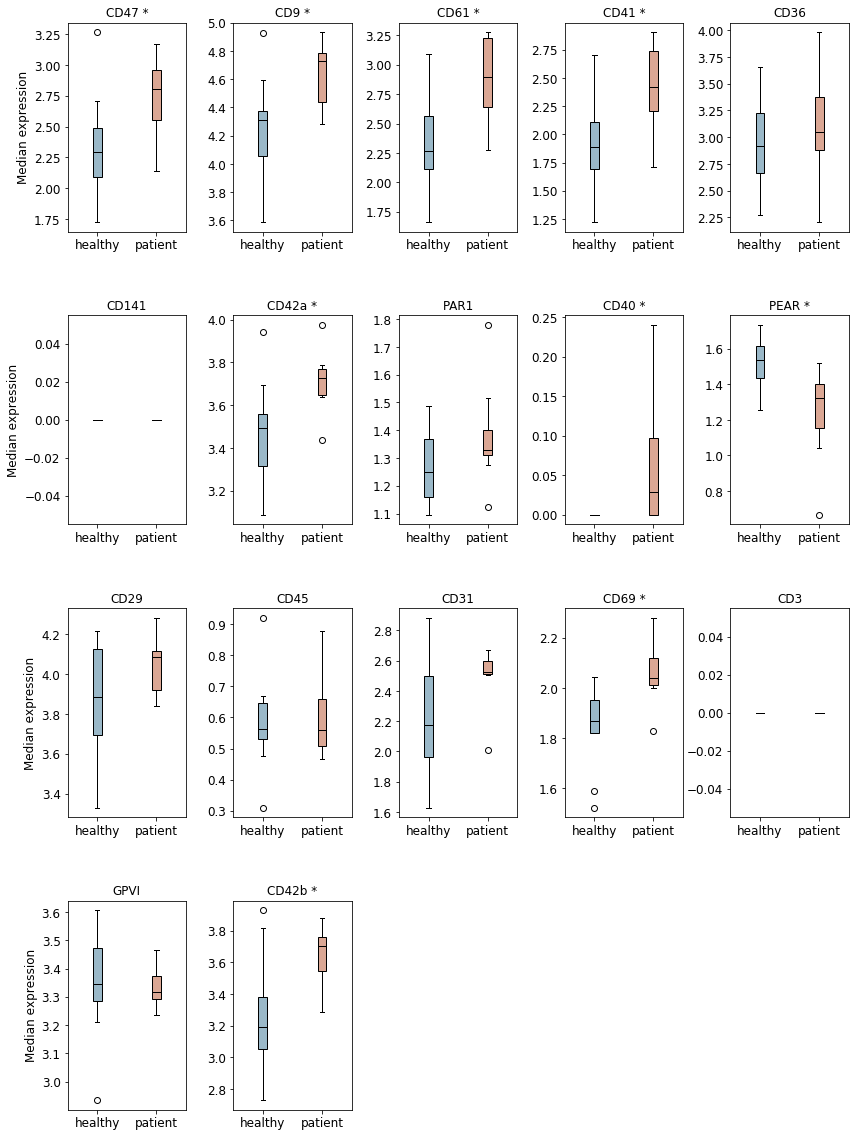

In [19]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
markers = panel

for i in range(len(panel)):
    ax = fig.add_subplot(4, 5, i+1)
    m= markers[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
    bp = ax.boxplot([d1,d2], labels = ["healthy", "patient"], patch_artist=True)
    if results_na.get(m)!=None:
        if results_na[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i %5 ==  0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/all_markers_baseline.pdf",dpi = 350)
    
plt.show()

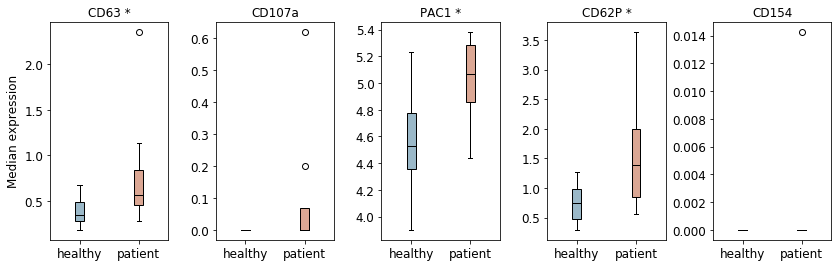

In [20]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

for i in range(len(act_m)):
    ax = fig.add_subplot(1, 5, i+1)
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
    bp = ax.boxplot([d1,d2], labels = ["healthy", "patient"], patch_artist=True)
    if results_na.get(m)!=None:
        if results_na[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i == 0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/activation_markers_baseline.pdf",dpi = 350)
    
plt.show()

### 2.2 Activated samples

In [21]:
warnings.filterwarnings("ignore")
model = "expression ~ condition"
results_act = pv_estimate(dat[dat.type == "activated"], markers, model)
results_act

{'CD47': 0.05283922562152305,
 'CD9': 0.01783220885791968,
 'CD61': 0.0008731803544351654,
 'CD41': 0.0,
 'CD36': 0.22396384822509702,
 'CD141': 0.3041977398806633,
 'CD42a': 0.18990233824862318,
 'PAR1': 0.6966209838880578,
 'CD40': 0.9149806852522805,
 'PEAR': 1.977328245797318e-25,
 'CD29': 0.18990233824862318,
 'CD45': 0.20500221511770392,
 'CD31': 0.22396384822509702,
 'CD69': 0.03192413831827594,
 'GPVI': 0.01783220885791968,
 'CD42b': 2.5564852684208737e-05}

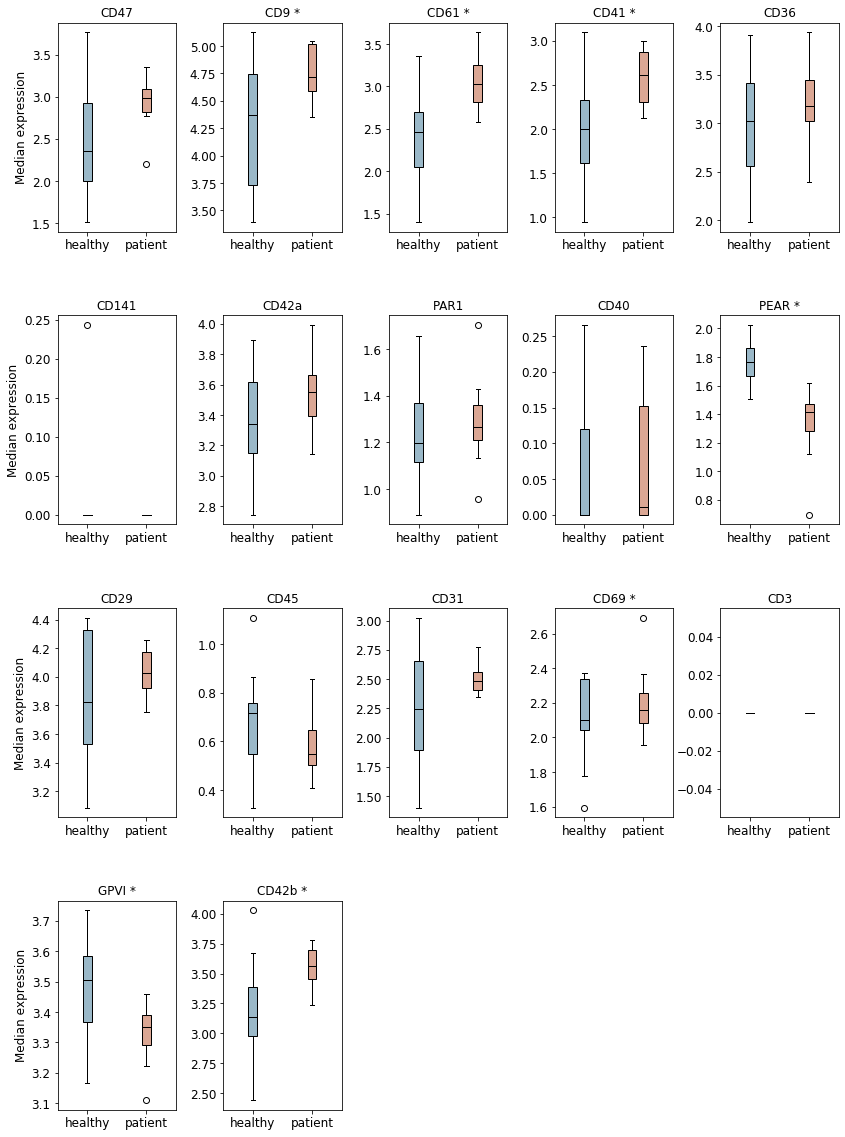

In [22]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

for i in range(len(panel)):
    ax = fig.add_subplot(4, 5, i+1)
    m= panel[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])
    bp = ax.boxplot([d1,d2], labels = ["healthy", "patient"], patch_artist=True)
    if results_act.get(m)!=None:
        if results_act[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i %5 ==  0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/all_markers_activated.pdf",dpi = 350)
    
plt.show()

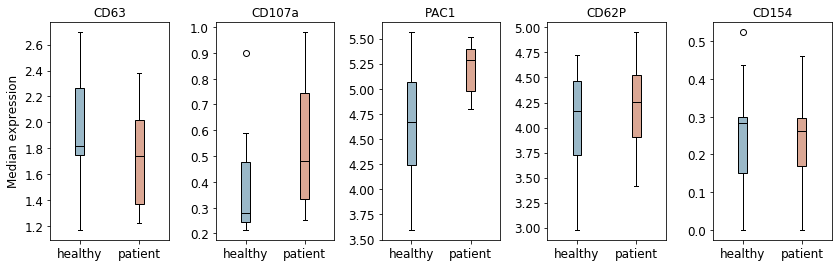

In [23]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
for i in range(len(act_m)):
    ax = fig.add_subplot(1, 5, i+1)
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])
    bp = ax.boxplot([d1,d2], labels = ["healthy", "patient"], patch_artist=True)
    if results_act.get(m)!=None:
        if results_act[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)    
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i == 0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/activation_markers_activated.pdf",dpi = 350)

plt.show()

### 2.3 Analysis of activated and not activated samples together (aggregated in one linear model)

In [24]:
warnings.filterwarnings("ignore")
model = "expression ~ condition + type"
results_all = pv_estimate(dat, markers, model)
results_all

{'CD47': 0.009282535043278176,
 'CD9': 6.268769960790318e-05,
 'CD61': 5.381605916712378e-05,
 'CD41': 3.54469001205832e-05,
 'CD36': 0.05682887714833498,
 'CD141': 0.4079627892786486,
 'CD42a': 0.009329567676169276,
 'PAR1': 0.3308107222792077,
 'CD40': 0.06435081429651711,
 'PEAR': 8.44683763937581e-08,
 'CD29': 0.05682887714833498,
 'CD45': 0.4079627892786486,
 'CD31': 0.05314581482207925,
 'CD69': 0.014158634568797714,
 'GPVI': 0.1127640530879643,
 'CD42b': 5.6598749315378936e-27}

## 3. Activation slope analysis

In [25]:
# add a column with patients IDs and pre-define same range for y axes|
dat["patient"] = [x[:-1] for x in dat["samples"]]
ylims = {"CD63": (0,3), "CD107a": (-0.1,1.1), "PAC1": (3.5, 5.8), "CD62P": (0, 5.6), "CD154": (-0.2,0.6)}

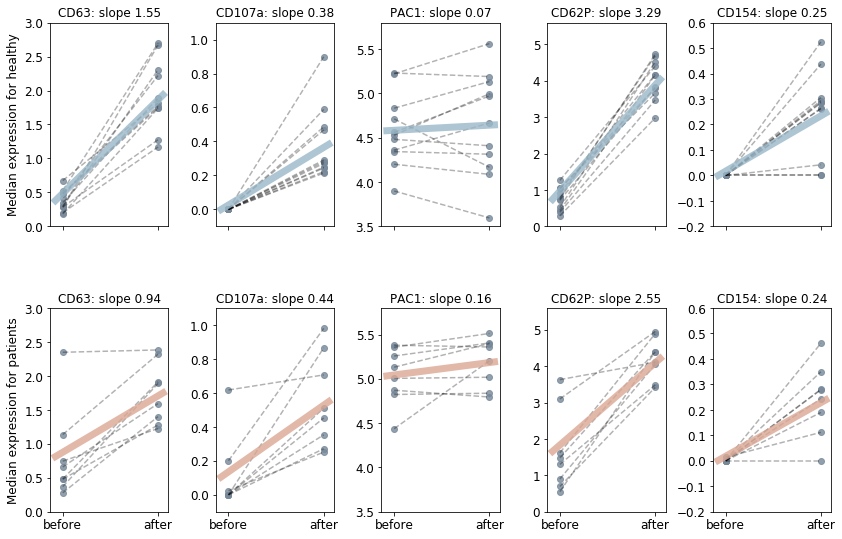

In [26]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
# top panel: only healthy
patients = list(set(dat[dat.condition == "healthy"]["patient"]))    
colors = ['#9AB8C8', '#DBA794']
for i in range(len(act_m)):
    ax = fig.add_subplot(2, 5, i+1)
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#778899", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#778899", alpha = 0.8)
    # compute the slope
    d = dat[(dat.marker == m) & (dat.condition == "healthy")]
    md = smf.mixedlm("expression ~ type",d ,
                 groups=d["samples"])
    mdf = md.fit()
    # print the slope in the plot title
    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
    # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median expression for healthy')
    # for each pair of patients plot a line from not activated sample to activated
    for p in patients:
        p1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")&(dat.patient == p)]["expression"])[0]

        p2 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")&(dat.patient == p)]["expression"])[0]

        
        plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    plt.plot(np.array(ax.get_xlim()),ys, c = '#9AB8C8', linestyle = "-", alpha = 0.8, linewidth=7)
    plt.ylim(ylims[m])
    
# same actions for patients on the bottom panel    
    
patients = list(set(dat[dat.condition == "patient"]["patient"]))    
for i in range(len(act_m)):
    ax = fig.add_subplot(2, 5, i+1+ len(act_m))
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])    
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#778899", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#778899", alpha = 0.8)
    d = dat[(dat.marker == m) & (dat.condition == "patient")]
    md = smf.mixedlm("expression ~ type",d ,
                 groups=d["samples"])
    mdf = md.fit()

    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
    

    if i == 0:
        ax.set_ylabel('Median expression for patients')
    for p in patients:
        p1 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")&(dat.patient == p)]["expression"])[0]

        p2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")&(dat.patient == p)]["expression"])[0]

        
        plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    plt.plot(np.array(ax.get_xlim()),ys, c = '#DBA794', linestyle = "-", alpha = 0.8,linewidth=7)
    plt.sca(ax)
    plt.xticks([1,2], ['before', 'after'])
    plt.ylim(ylims[m])

#plt.savefig("vectors/activation_all_together.pdf",dpi = 350)
plt.show()


In [27]:
dat[dat.condition == "healthy"]

,expression,samples,marker,condition,type,patient
0,1.719918,CVD001B,CD41,healthy,not activated,CVD001
2,2.003366,CVD003B,CD41,healthy,not activated,CVD003
4,1.221145,CVD006B,CD41,healthy,not activated,CVD006
5,1.807720,CVD007B,CD41,healthy,not activated,CVD007
8,1.899686,CVD010B,CD41,healthy,not activated,CVD010
...,...,...,...,...,...,...
827,3.889713,CVD013A,CD42a,healthy,activated,CVD013
831,3.420758,CVD019A,CD42a,healthy,activated,CVD019
832,3.664011,CVD012A,CD42a,healthy,activated,CVD012
833,3.067206,CVD020A,CD42a,healthy,activated,CVD020


## 4. UMAP based on pre-computed coordinates

UMAP was performed with CATALYST R package. You can reproduce the plot using umap.csv file

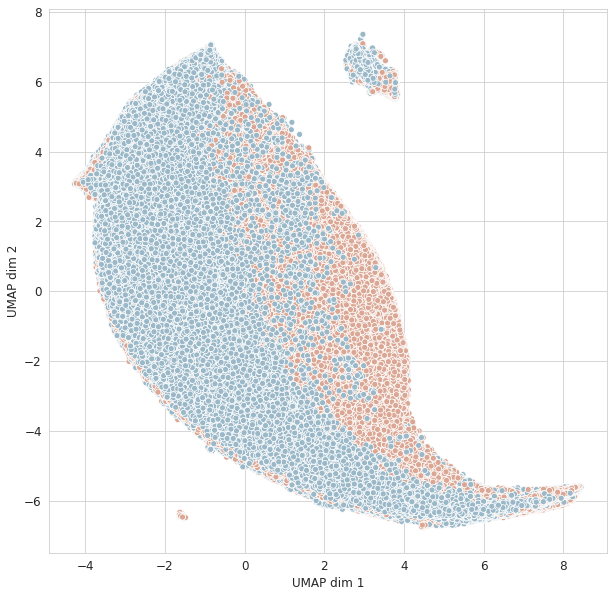

In [31]:
umap = pd.read_csv("data/umap.csv")
sns.set_style("whitegrid")
markers = {"healthy": "s", "patient": "X"}
fig = plt.figure(figsize=(10, 10))

ax = sns.scatterplot(x="x", y="y", hue="condition",
                     data=umap, palette= colors, alpha = 1,legend = False)
ax.set(xlabel='UMAP dim 1', ylabel='UMAP dim 2')

fig = ax.get_figure()

#fig.savefig("vectors/umap_condition.png", dpi = 350)

plt.show()